<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/RadiopharmaceuticalNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas contextily shapely pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 12.0 MB/s eta 0:00:00


In [2]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import itertools

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import pandas as pd
import numpy as np

In [3]:
hospitals = {
    "Michigan Diagnostics Center": (42.48853947067958, -83.10526194019599),
    "Nuclear Medicine PET Scan at University Hospital": (42.373423665779875, -83.74705677218591),
    "Regional Medical Imaging Southgate": (42.25969201846909, -83.17027457939628),
    "Beaumont PET/CT St. Clair Shores": (42.56791387603854, -82.8846300648719),
    "Regional Medical Imaging Novi": (42.49902362908627, -83.42865686601002),
    "Henry Ford Radiology and Imaging - Macomb Hospital": (42.64671830391097, -82.96015224192095),
    "Computed Tomography (CT/CAT scan) at Livonia Center for Specialty Care": (42.452871313282124, -83.43988814124502),
    "Computed Tomography (CAT/CT scan) at East Ann Arbor Health and Geriatrics Center": (42.34030658958308, -83.677349389071),
    "Synergy MRI: Royal Oak - Pure Open MRI": (42.50612096423798, -83.14466604935329),
    "Michigan Resonance Imaging": (42.6915481520167, -83.23932965490553),
    "Computed Tomography (CAT/CT scan) at Canton Health Center": (42.35216501570914, -83.48962664585721),
    "Therma-Scan of Michigan, LLC": (42.53450224783935, -83.28906815951773),
    "Life Scan Imaging Corporation": (42.55223400342188, -83.01309968231458),
    "Scan Clear MRI": (42.639636951333856, -82.96175670981167),
    "McLaren Clarkston - Diagnostic Imaging": (42.749307331742, -83.38212729717925),
    "Corewell Health William Beaumont University Hospital Imaging Center - 3581 W 13 Mile Rd": (42.53686677288904, -83.19761348974691),
    "Corewell Health Farmington Hills Hospital Cancer PET - 27900 Grand River Ave": (42.46115756857247, -83.32917985678563),
    "Michigan Diagnostics": (42.56405237592633, -83.18156881083976),
    "University of Michigan Department of Radiology": (42.31065073827846, -83.7367147010275),
    "Magnetic Resonance Imaging (MRI) at University Hospital": (42.31302372082438, -83.74313257259035),
    "University of Michigan Radiology Department": (42.3308182381527, -83.66451364594526),
    "Henry Ford Radiology and Imaging - Henry Ford Hospital": (42.39483682739532, -83.09332307685038),
    "Cat Scan Center-Clarkston": (42.75048553064453, -83.42223899444716),
    "Karmanos Cancer Institute": (42.37587515709506, -83.0548158474732),
    "Corewell Health William Beaumont University Hospital Imaging Center (North) - 3601 West 13 Mile Rd": (42.54750602768598, -83.18798668240262),
    "University of Michigan Hospital": (42.3082776662676, -83.73029682946462),
    "West Ann Arbor Health Center": (42.30617469480637, -83.81869373445174),
    "Corewell Health Farmington Hills Hospital": (42.492773027416945, -83.32430899777493),
    "U of M nuclear medicine": (42.30567431128067, -83.73610211287075),
    "Xoran Technologies, LLC.": (42.2347479291253, -83.74979481977397),
    "H C S Group": (42.38891163244826, -83.47602561421753),
    "Brighton Center for Specialty Care": (42.5569552581989, -83.78832668728445),
    "Barbara Ann Karmanos Cancer Institute - Lawrence and Idell Weisberg Cancer Treatment Center": (42.53715336348327, -83.34675344872672),
    "Henry Ford Cancer - Detroit": (42.38923356016813, -83.08820419968758),
    "Bionicc Body Screening": (42.50779307035835, -83.26398543939487),
    "Medical Scan Inc": (42.60591583149083, -83.15000229177215),
    "Henry Ford Medical Center - Sterling Heights": (42.57052850357885, -83.07172470846498),
    "Corewell Health Dearborn Hospital": (42.31616234192726, -83.20218734731026),
    "University of Michigan Medical Center": (42.30302607557066, -83.73009342374314),
    "Henry Ford Hospital": (42.39578802444869, -83.07850907813186),
    "Children's Hospital of Michigan": (42.37245750030311, -83.0524165503628),
    "DMC Detroit Receiving Hospital": (42.371442933019594, -83.0524165503628),
    "McLaren Clarkston": (42.75377544900855, -83.36983337813187),
    "Huron Gastro Ann Arbor": (42.28356418243363, -83.6595742965488),
}

depot = {
    "EHMET health": (42.42980168639475, -83.52695942935674)
}

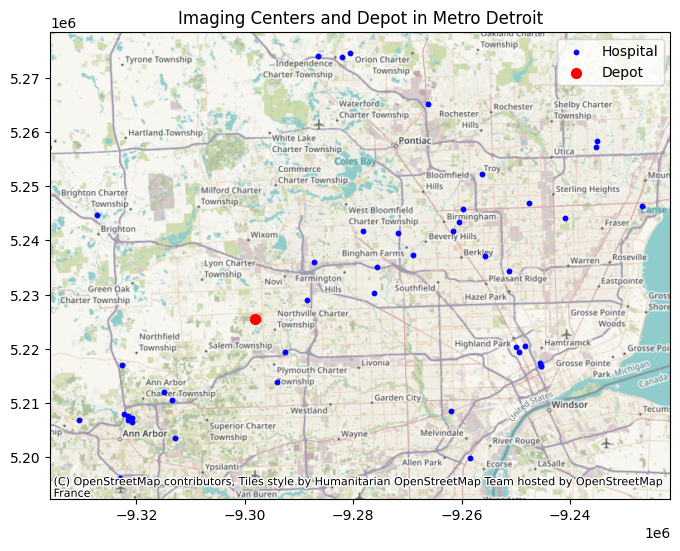

In [4]:
# 1. Build GeoDataFrames
hospital_points = []
for name, (lat, lon) in hospitals.items():
    # Note: geometry expects (longitude, latitude)
    hospital_points.append([name, Point(lon, lat)])

hospitals_gdf = gpd.GeoDataFrame(
    hospital_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

depot_points = []
for name, (lat, lon) in depot.items():
    depot_points.append([name, Point(lon, lat)])

depot_gdf = gpd.GeoDataFrame(
    depot_points,
    columns=["Name", "geometry"],
    crs="EPSG:4326"
)

# 2. Reproject to Web Mercator
hospitals_3857 = hospitals_gdf.to_crs(epsg=3857)
depot_3857 = depot_gdf.to_crs(epsg=3857)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot hospitals in blue
hospitals_3857.plot(
    ax=ax,
    color='blue',
    markersize=10,
    label='Hospital'
)

# Plot depot in red
depot_3857.plot(
    ax=ax,
    color='red',
    markersize=50,
    label='Depot'
)

# Add a basemap behind it
cx.add_basemap(ax, crs=hospitals_3857.crs)

ax.legend()
plt.title("Imaging Centers and Depot in Metro Detroit")
plt.show()

In [5]:
# Distance Matrix Generator
nodes = {**depot, **hospitals} # Ensures depot is node 0

# Create a list of node names
node_names = list(nodes.keys())

# Define the haversine function to calculate distances
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points on Earth."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c  # Earth's radius in km
    return km

# Initialize an empty DataFrame for the distance matrix
distances = pd.DataFrame(index=node_names, columns=node_names, dtype=float)

# Compute pairwise distances using the haversine formula
for name1 in node_names:
    lat1, lon1 = nodes[name1]
    for name2 in node_names:
        lat2, lon2 = nodes[name2]
        distances.loc[name1, name2] = haversine(lon1, lat1, lon2, lat2)

# Calculates the travel times and cost matrices
vehicle_speed = 60 # km/hour

t = (distances / vehicle_speed) * 60  # travel times in minutes
c = distances * 0.093  # travel costs

In [8]:
V = range(45)  # nodes including depot, 0 is depot
V_star = range(1, 45)  # nodes excluding depot
K = range(22)
vehicle_speed = 60  # vehicle speed in km/h

In [10]:
# Time window parameters (converted into minutes)
# First element of array is for the depot
a = [0, 480, 0, 450, 420, 390, 0, 480, 480, 450, 0, 480, 540, 0, 510, 420, 420, 480, 480, 480, 0, 0, 390, 0, 0, 480, 0, 420, 0, 0, 540, 0, 420, 420, 420, 540, 0, 0, 0, 0, 0, 0, 0, 0, 480]
b = [1440, 1020, 1440, 1170, 960, 1320, 1440, 990, 990, 1080, 1440, 990, 1020, 1440, 1020, 1110, 1020, 720, 1020, 1020, 1440, 1440, 1350, 1440, 1440, 1020, 1440, 1140, 1440, 1440, 1020, 1440, 1140, 1020, 1140, 1080, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1020]
s = [0] + [30] * (len(a) - 1) # Assume 30 min service per customer

num_customers = len(a) - 1
d = [0] + list(np.random.randint(1, 16, size=num_customers))
p = [0] + list(np.random.randint(1, 16, size=num_customers))

num_vehicles = 22
Q = list(np.random.randint(47, 114, size=num_vehicles))

cost_factor = 2.5
fixed_cost = [round(q * cost_factor, 2) for q in Q]